In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
df = pd.read_csv('../data/migraine.csv')
pd.set_option('display.float_format', '{:0.2f}'.format)

In [3]:
print(df.groupby('Type').size())

Type
Basilar-type aura                 18
Familial hemiplegic migraine      24
Migraine without aura             60
Other                             17
Sporadic hemiplegic migraine      14
Typical aura with migraine       247
Typical aura without migraine     20
dtype: int64


In [4]:
X = df.iloc[:, :-1].astype(np.float32)
y = df['Type']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

num_classes = 7

In [5]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

# Konwersja etykiet na format one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded, num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded, num_classes)

In [6]:
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64, activation='relu'))  # Warstwa ukryta z 64 neuronami i funkcją aktywacji ReLU
model.add(tf.keras.layers.Dense(32, activation='relu'))  # Kolejna warstwa ukryta z 32 neuronami i funkcją aktywacji ReLU
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))  # Warstwa wyjściowa z funkcją aktywacji softmax
model.build(input_shape=23)
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [7]:
history = model.fit(X_train,y_train_one_hot,epochs=50,verbose=1,validation_split=0.2)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1504 - loss: 1.9134 - val_accuracy: 0.6500 - val_loss: 1.7580
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6451 - loss: 1.7386 - val_accuracy: 0.6500 - val_loss: 1.5442
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6085 - loss: 1.5358 - val_accuracy: 0.6500 - val_loss: 1.3543
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5758 - loss: 1.3931 - val_accuracy: 0.6500 - val_loss: 1.2197
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6078 - loss: 1.2929 - val_accuracy: 0.6500 - val_loss: 1.1358
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6206 - loss: 1.1934 - val_accuracy: 0.6500 - val_loss: 1.0815
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6170 - loss: 1.1453 - val_accuracy: 0.6500 - val_loss: 1.0326
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5978 - loss: 1.1591 - val_accuracy: 0.6500 - val_loss: 0.9999
Epoch 9

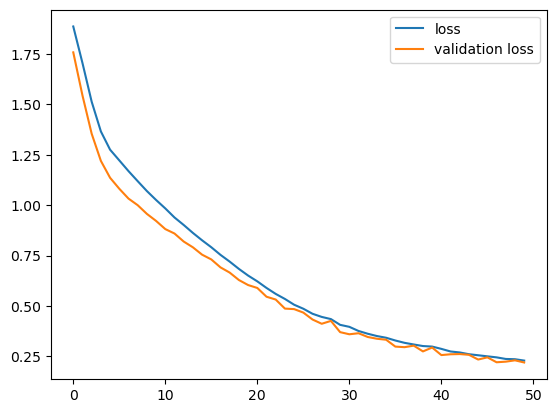

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','validation loss'])
plt.show()

In [9]:
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [10]:
shap.initjs()

In [11]:
def f(X):
    return model.predict([X[:, i] for i in range(X.shape[1])]).flatten()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
19613/19613 ━━━━━━━━━━━━━━━━━━━━ 4s 216us/step


100%|██████████| 1/1 [00:07<00:00,  7.95s/it]


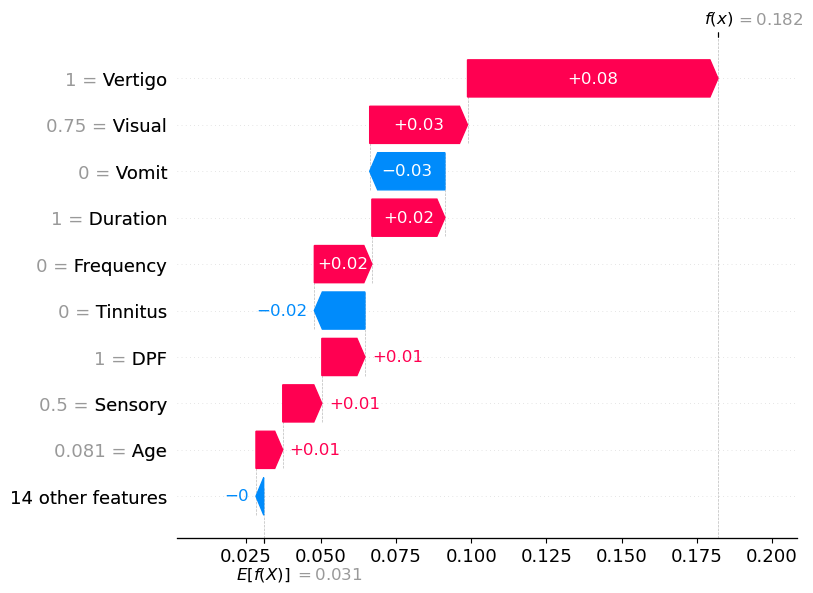

In [12]:
def predict(X):
    return model.predict(X)

# Tworzenie wyjaśniacza KernelExplainer
explainer = shap.KernelExplainer(predict, X_train)

# Obliczanie wartości SHAP dla przykładowych danych
shap_values = explainer.shap_values(X_test[0:1])  # X_test to dane testowe, wybieramy przykład 0

# Tworzenie obiektu Explanation z etykietami cech
explanation = shap.Explanation(values=shap_values[0][0], 
                               base_values=explainer.expected_value[0], 
                               data=X_test[0],
                               feature_names=df.columns)

# Wyświetlanie wykresu wodospadowego
shap.waterfall_plot(explanation)

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
19613/19613 ━━━━━━━━━━━━━━━━━━━━ 5s 229us/step


100%|██████████| 1/1 [00:07<00:00,  7.10s/it]


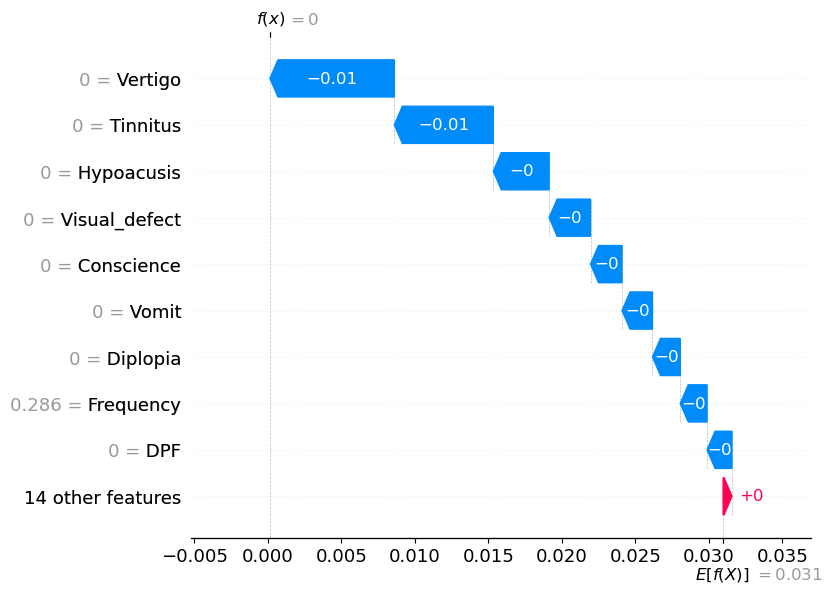

In [13]:
# Obliczanie wartości SHAP dla przykładowych danych
shap_values = explainer.shap_values(X_test[1:2])  # X_test to dane testowe, wybieramy przykład 299

# Tworzenie obiektu Explanation z etykietami cech
explanation = shap.Explanation(values=shap_values[0][0], 
                               base_values=explainer.expected_value[0], 
                               data=X_test[1],
                               feature_names=df.columns)

# Wyświetlanie wykresu wodospadu
shap.waterfall_plot(explanation)

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
19613/19613 ━━━━━━━━━━━━━━━━━━━━ 5s 248us/step


100%|██████████| 1/1 [00:09<00:00,  9.25s/it]


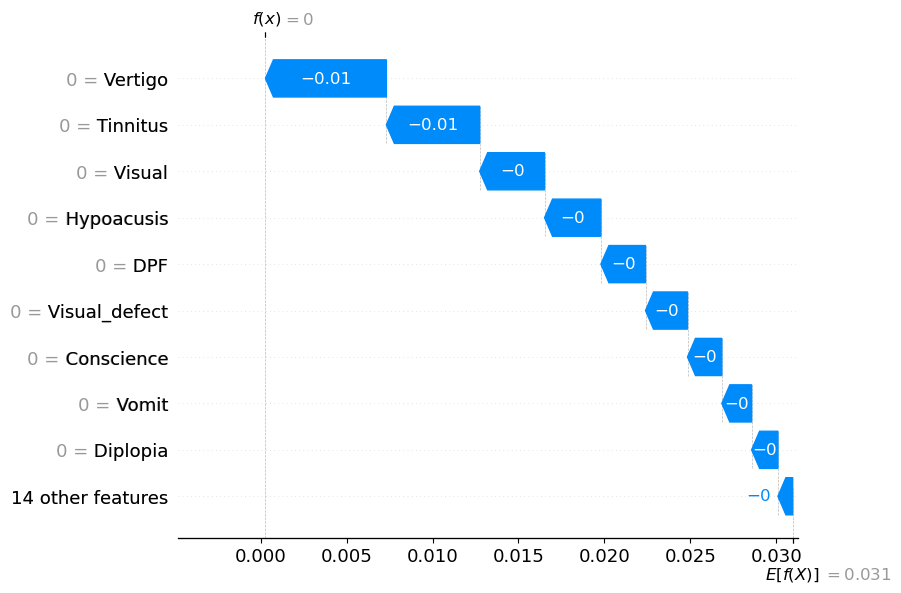

In [14]:
# Obliczanie wartości SHAP dla przykładowych danych
shap_values = explainer.shap_values(X_test[49:50])  # X_test to dane testowe, wybieramy przykład 299

# Tworzenie obiektu Explanation z etykietami cech
explanation = shap.Explanation(values=shap_values[0][0], 
                               base_values=explainer.expected_value[0], 
                               data=X_test[49],
                               feature_names=df.columns)

# Wyświetlanie wykresu wodospadu
shap.waterfall_plot(explanation)

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
19613/19613 ━━━━━━━━━━━━━━━━━━━━ 5s 237us/step


100%|██████████| 1/1 [00:07<00:00,  7.64s/it]


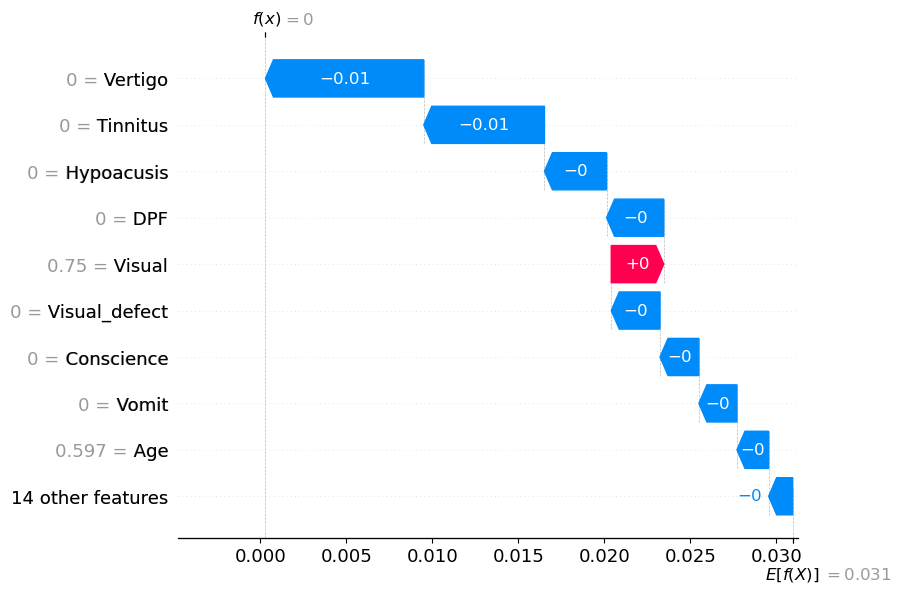

In [15]:
# Obliczanie wartości SHAP dla przykładowych danych
shap_values = explainer.shap_values(X_test[80:81])  # X_test to dane testowe, wybieramy przykład 299

# Tworzenie obiektu Explanation z etykietami cech
explanation = shap.Explanation(values=shap_values[0][0], 
                               base_values=explainer.expected_value[0], 
                               data=X_test[80],
                               feature_names=df.columns)

# Wyświetlanie wykresu wodospadu
shap.waterfall_plot(explanation)

In [17]:
shap.plots.beeswarm(shap_values)

TypeError: The beeswarm plot requires an `Explanation` object as the `shap_values` argument.